In [1]:
from pathlib import Path
import os

from astropy.nddata import CCDData
from astropy.visualization import hist
from astropy.stats import mad_std

import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np
import sys
from astropy import units as u


sys.path.append("/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline")
import fpnfix
from aperturePhot import showimage as show_image

In [2]:
path = "/home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/"
day = "20201118"
path_day = os.path.join(path, day)

data_red = Path(path_day, "Reduced_Images")
data_red.mkdir(exist_ok = True)

In [3]:
files = ccdp.ImageFileCollection(path_day)
files.summary['file', 'imagetyp', 'filter', 'exptime', 'naxis1', 'naxis2']

file,imagetyp,filter,exptime,naxis1,naxis2
str24,str11,object,float64,int64,int64
BL _Lac-001B.fit,Light Frame,Bessel B,60.0,1024,1024
BL _Lac-001R.fit,Light Frame,Bessel R,60.0,1024,1024
BL _Lac-001V.fit,Light Frame,Bessel V,60.0,1024,1024
BL_Lac-001B.fit,Light Frame,Bessel B,60.0,1024,1024
BL_Lac-001R.fit,Light Frame,Bessel R,60.0,1024,1024
BL_Lac-001V.fit,Light Frame,Bessel V,60.0,1024,1024
BL_Lac-002B.fit,Light Frame,Bessel B,60.0,1024,1024
BL_Lac-002R.fit,Light Frame,Bessel R,60.0,1024,1024
BL_Lac-002V.fit,Light Frame,Bessel V,60.0,1024,1024


In [4]:
calibrated_biases = files.files_filtered(imagetyp='Bias Frame', include_path=True)

combined_bias = ccdp.combine(calibrated_biases,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit = "adu")

combined_bias.meta['combined'] = True

combined_bias.write(os.path.join(data_red / 'combined_bias.fit'), overwrite = True)

In [5]:
calibrated_darks = files.files_filtered(imagetyp='Dark Frame', include_path=True)
reduced_darks= []
exptime= []

for frame in calibrated_darks:
    image = ccdp.CCDData.read(frame, unit = 'adu')
    exptime.append(image.header["exposure"])
    reduced_darks.append(ccdp.subtract_bias(image, combined_bias))
    
combined_darks = ccdp.combine(reduced_darks,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit = "adu", scale =1 / np.array(exptime))

combined_darks.header["exposure"] = 1
combined_darks.header['exptime'] = 1

combined_darks.meta['combined'] = True

combined_darks.write(os.path.join(data_red / 'combined_darks.fit'), overwrite = True)

In [6]:
flat_imagetyp = 'Flat Field'

flat_filters = set(h['filter'] for h in files.headers(imagetyp=flat_imagetyp))
flat_filters

{'Bessel B', 'Bessel R', 'Bessel V'}

In [7]:
scale = lambda a: 1/np.median(a)

master_flats = {}

for filt in flat_filters:
    reduced_flats = []
    calibrated_flats = files.files_filtered(imagetyp = flat_imagetyp, filter = filt, include_path=True)
    
    for flat in calibrated_flats:
        image = ccdp.CCDData.read(flat, unit = "adu")
        image = ccdp.subtract_bias(image, combined_bias)
        image = ccdp.subtract_dark(image, combined_darks, scale=True, exposure_unit=u.s, exposure_time = "exptime")
        #image = fpnfix.subtract_fpn(image,combfpn[60],mesh_size=32, verbose = 2)
        reduced_flats.append(image)
    
    combined_flats = ccdp.combine(reduced_flats,
                                 method='median',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std, unit = "adu", scale = scale
                                )

    master_flats[filt]=combined_flats.copy()

    combined_flats.write(data_red / (filt.replace("","_")+"_combined_flats.fit"), overwrite = True)

784.7504558563232 1.4826
778.5 795.1425547257056


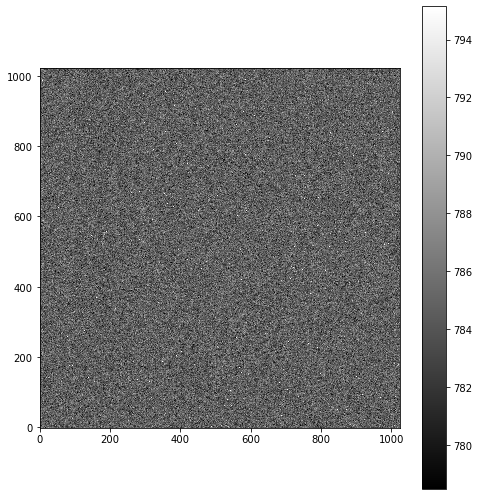

In [8]:
show_image(combined_bias)

0.25500260988871254 0.061775000000000024
0.041666666666666664 0.5690647048211506


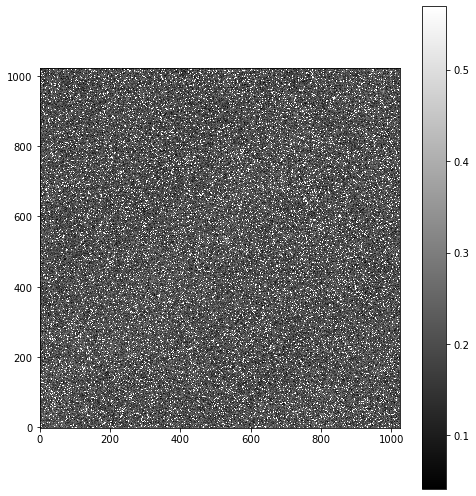

In [9]:
show_image(combined_darks)

0.9998468007992259 0.007095463893012
0.9677236906602315 1.0230383469703253


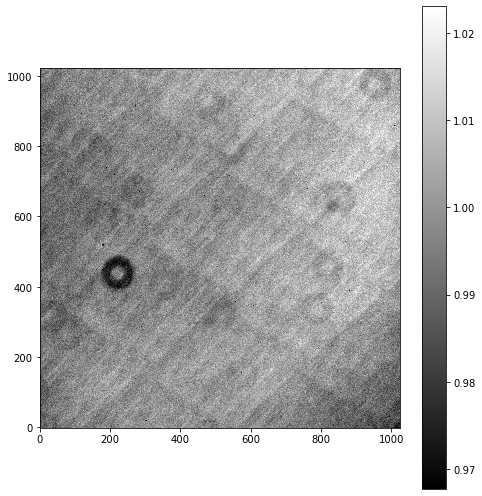

0.999873676166903 0.007171006731677968
0.9671918099663666 1.0181752310317638


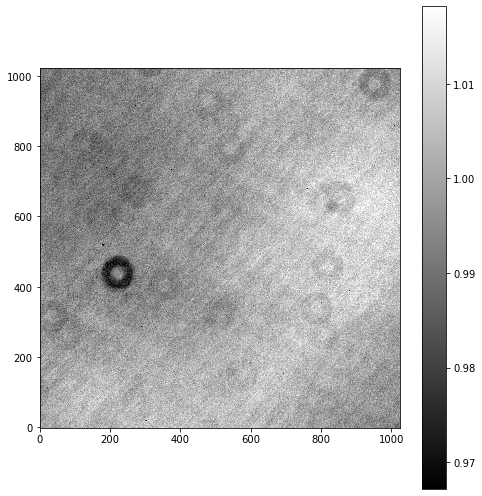

1.003371210042323 0.009809571743826795
0.9605987872100938 1.0602068327319807


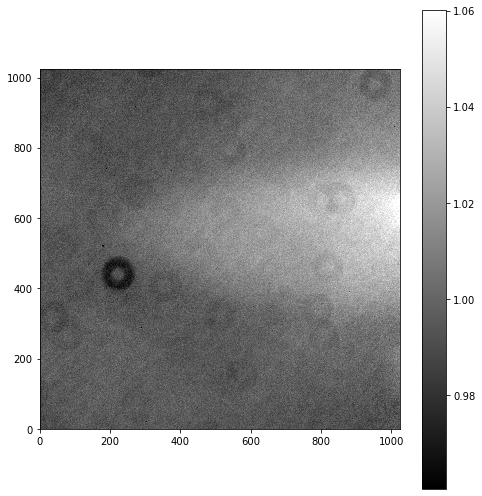

In [10]:
for filt,image in master_flats.items():
    show_image(image)

In [11]:
import ccdproc
images = files.files_filtered(imagetyp="Light Frame", include_path = True)

for image in images:
    var = ccdp.CCDData.read(image, unit = "adu")
    var_filt = var.header["filter"]
    
    corr_filt = master_flats[var_filt]
    
    var = ccdproc.ccd_process(var,
                             master_bias = combined_bias, dark_frame = combined_darks,
                             master_flat = corr_filt, exposure_key="exposure", exposure_unit = u.second,
                             dark_scale = True)
    proc_data = os.path.basename(image)
    var.write(data_red / ("BDF_"+proc_data), overwrite = True)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
374.9621844508544 15.14858695898453
329.1516131443726 463.4364762804817


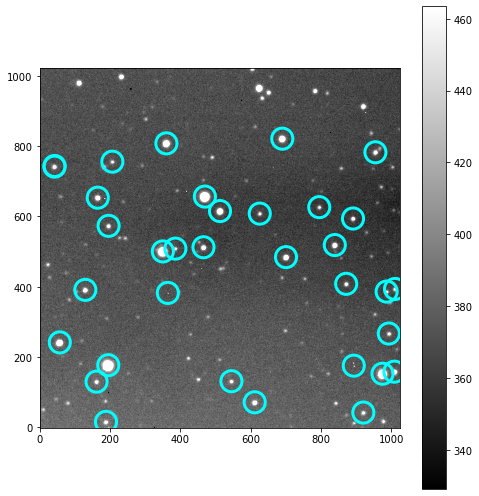

      xcentroid   ycentroid       mag
8    194.633305  176.979071 -4.815582
27   469.520371  656.669498 -4.413997
5    974.745122  152.650460 -4.147581
17   349.870539  500.605541 -4.106427
32   360.027074  808.073884 -2.485031
33   689.713092  821.437912 -2.350765
24   512.503177  615.455825 -2.295691
9     56.653981  241.841354 -2.121082
16   700.297465  484.428120 -1.723593
20   839.089896  518.730023 -1.584687
6   1008.743540  158.533575 -1.546159
7    893.116180  175.589113 -1.477786
2    611.274917   71.375443 -1.342404
19   465.497723  512.464956 -1.063757
11   364.074291  382.575198 -1.011862
26   164.675252  653.537259 -0.972301
31   954.651140  782.766964 -0.811280
22   890.923396  594.230951 -0.745150
23   625.584404  608.203883 -0.675484
13   129.255783  391.230530 -0.611754
15   871.482826  408.392347 -0.550374
12   986.551991  386.399841 -0.522979
14  1010.493205  393.824261 -0.458367
0    188.161183   15.625859 -0.404282
30   206.176556  755.999007 -0.395343
4    544.996

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


Return code: 0 


dxfit [3.81735991e+02 1.60015035e+00 2.76696174e-01]
dyfit [ 5.15628986e+02 -2.77062934e-01  1.59998360e+00]

scalex, scaley: 0.6158025501447589 0.6158411466618057
anglex, angley: -9.810507422775595 -9.824261918802783
fracdiffs: 0.0014020167800144474 6.267677364711722e-05

# Created by grmatch 0.9e0 (fi: 0.9.4)
# Invoked command: /home/idies/workspace/Storage/madisonleblanc/persistent/bin/grmatch -r /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201118/Reduced_Images/BDF_HH_And_0001_001R.gaia.proj -i /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201118/Reduced_Images/BDF_HH_And_0001_001R.stars.csv -o /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201118/Reduced_Images/BDF_HH_And_0001_001R.match.csv --match-points --col-ref 4,5 --col-inp 2,3 --output-transformation /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201118/Reduced_Images/BDF_HH_And_00

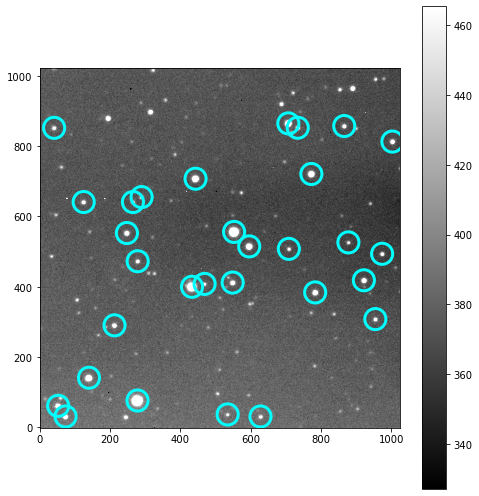

      xcentroid   ycentroid       mag
4    277.796068   76.401134 -5.068913
19   552.480000  556.137104 -4.684014
9    432.907477  400.027759 -4.382309
23   442.983075  707.501449 -2.719308
29   706.919965  864.914891 -2.688628
16   595.583020  514.945328 -2.674305
24   772.387056  720.932247 -2.562028
5    139.731861  141.183856 -2.383559
8    783.256768  383.966751 -2.057710
12   921.822294  418.522760 -1.740199
3     52.007771   61.373135 -1.430349
11   548.557711  412.056971 -1.417809
25  1002.934707  813.143815 -1.318145
18   247.682816  552.914282 -1.316109
6    212.377821  290.344788 -1.105472
28   865.921936  857.376374 -0.893462
0     73.133004   31.130572 -0.884919
14   973.707584  493.892086 -0.838912
26   733.692297  852.569328 -0.807409
13   278.236301  472.714744 -0.699656
7    954.410104  308.099079 -0.664417
20   124.660683  641.156817 -0.632864
1    627.632404   31.012724 -0.449611
10   468.638026  408.202449 -0.429370
21   264.800624  641.118516 -0.376162
2    534.239

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
372.3653054238103 15.098305040962183
313.4979259665076 458.5904972335156


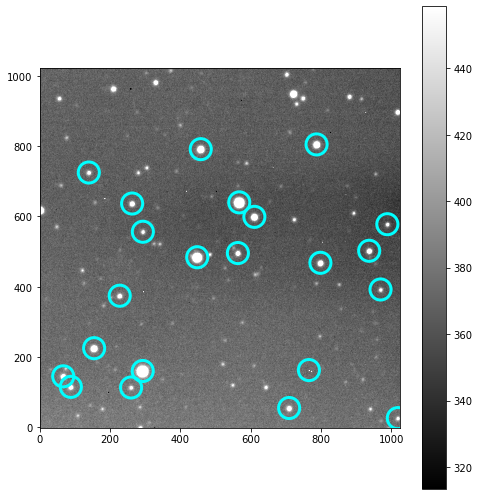

      xcentroid   ycentroid       mag
5    292.591909  160.472350 -4.473702
18   567.261948  640.153533 -4.096901
11   447.686628  484.117227 -3.845821
20   457.692476  791.546773 -2.207784
21   787.251675  805.062001 -2.111872
16   610.228880  599.000966 -2.025421
7    154.373757  225.338126 -1.770765
6    765.447279  163.049675 -1.638892
10   798.113905  468.227545 -1.321107
13   936.881275  502.449479 -1.145817
12   563.347976  496.005432 -1.023825
1    709.125705   55.069469 -0.936343
4     66.394926  145.312102 -0.931901
17   262.446948  636.924031 -0.775818
8    227.153381  374.609662 -0.587056
3     88.116124  115.202972 -0.364048
15   988.595297  578.044734 -0.353187
19   139.207459  725.180304 -0.275268
9    969.202350  392.352376 -0.236125
0   1018.362686   26.312365 -0.150404
14   292.949622  556.577933 -0.114815
2    259.476605  113.473745 -0.046437
Point RA 23 41 52
Point Dec +44 10 18
objcoord <SkyCoord (ICRS): (ra, dec) in deg
    (355.46666667, 44.17166667)>
radecstr 35

/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:298: RuntimeWarning: divide by zero encountered in double_scalars
  scalex = 1.0/(dxfit[1]/np.cos(anglex))
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:299: RuntimeWarning: divide by zero encountered in double_scalars
  scaley = 1.0/(dyfit[2]/np.cos(angley))
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:301: RuntimeWarning: invalid value encountered in double_scalars
  fracanglediff = np.abs((anglex - angley)/anglex)
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:302: RuntimeWarning: invalid value encountered in double_scalars
  fracscalediff = np.abs((scalex-scaley)/scalex)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


        ra                dec         phot_g_mean_mag
       deg                deg               mag      
------------------ ------------------ ---------------
355.45682608764184   44.1091497298546        10.34314
355.47999369869643 44.170596761287726       10.365541
 355.5019035183828 44.198035374175014       10.528759
 355.3306982581766   44.2359279272418       11.300747
355.50456763922585  44.06754318511075       11.603616
355.41842256644543  44.05138045696271       11.614873
 355.3698096839802  44.17781222041276       12.348801
355.47001979053437  44.22036113755551       12.442065
355.52571998929113  44.25459544396694       12.642408
 355.5469803797695  44.23222573087555       12.708231
               ...                ...             ...
355.34559411407037  44.13051842761099      13.7032585
355.32943133886914  44.21949946113691       13.769068
 355.5413980430078   44.0704101181017      13.8390465
 355.5720328787715  44.08194082025348       13.874222
355.43035433548386   44.1886

381.3743841006759 15.212206433590337
322.718171778585 469.65256891052195


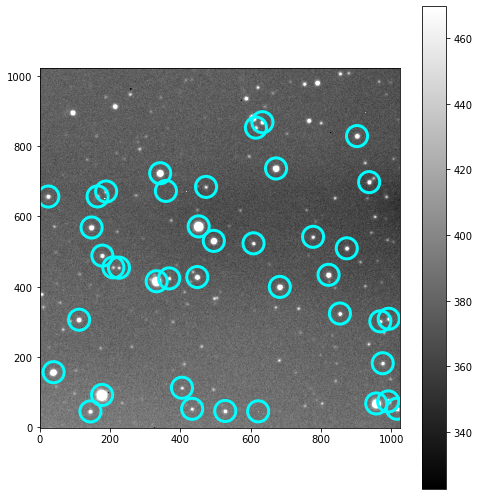

      xcentroid   ycentroid       mag
7    176.997100   92.256251 -5.368847
28   451.824618  571.842800 -4.935875
16   332.244032  415.802978 -4.688189
5    957.036966   68.019877 -4.541928
35   342.312727  723.213891 -3.007771
25   494.841355  530.636460 -2.877784
36   671.920209  736.644137 -2.858424
9     38.998722  157.044854 -2.665432
15   682.624121  399.685929 -2.230337
6    991.012621   73.884603 -1.996625
19   821.375300  434.004770 -1.993777
18   447.874483  427.767798 -1.767399
27   147.106705  568.665036 -1.664661
37   902.366221  828.794427 -1.618624
12   111.601434  306.342510 -1.323597
34   936.813979  697.820919 -1.271838
23   873.142919  509.467373 -1.165484
39   633.142093  868.246196 -1.061339
4   1016.321783   53.003003 -1.033921
22   177.752060  488.667034 -0.990395
24   607.816170  523.656807 -0.963689
29    24.008327  656.744627 -0.920684
14   853.666719  323.853195 -0.911566
10   975.389807  182.561083 -0.875769
0    143.853810   45.479185 -0.868271
13   992.557

In [12]:
import plateSolve
pathlist = Path(data_red).glob('BDF_HH_And*R.fit')

for path in pathlist:
    #show_image(Rimage)
    Rimage = ccdp.CCDData.read(path, unit="adu")
    
    check = plateSolve.autoSolve(path,Rimage, verbose = 1)
    if (check == True):
        #print(check)
        print(Rimage.header['JD-HELIO'])
        print("______________________________________________")
        
    else:
        print("!!!!!!!Plate solve did not work for", path)
        print("______________________________________________")
        print(" ")

In [ ]:
plateSolve.manualSolvePlot(V,Vimage)

In [ ]:
gaia_list = [0,1, 3, 9, 12,17,22,24,54]
image_list = [0,1,4,5,8, 11, 13, 15,16]

check = plateSolve.manualSolve(V,Vimage,gaia_list,image_list)
print("Check is True if successful")
print(V,check)